In [58]:
import xarray as xr
import glob
import numpy as np
import netCDF4 as nc
import warnings
import matplotlib.path as mpath
import cartopy.feature as cfeature

warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
from cmocean import cm
import warnings
warnings.filterwarnings('ignore')
import cartopy.crs as ccrs
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/')
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS/')
import scendict as sc
import utils as ut

We are struggling to see a good response signal in the air-sea co2 flux from the winds. why?


xx- notebook here

We see that the wind increases are sorta limited to certain latitude bands:
https://nbviewer.org/github/tjarnikova/SOZONE/blob/master/windAnalyis/LatitudinalWinds.ipynb

Here are the latitudinal bands I've decided to work with:

In [59]:
def plot_southern(fig, ax1, lons, lats, tdat, tvmin, 
                  tvmax, tticks, northex = -50, fs = 12, 
                  tit = '', cbarlab = '', tcmap = 'viridis', lm = True, cbr = True):
   
    ax1.set_extent([-180, 180, -80, -25], ccrs.PlateCarree())
    #make that circle
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax1.set_boundary(circle, transform=ax1.transAxes)
    lons = nav_lon[0:50,:]; lats = nav_lat[0:50,:]; 
    mesh = ax1.pcolormesh(lons, lats, tdat, cmap = tcmap, vmin = tvmin, vmax = tvmax, 
                     transform=ccrs.PlateCarree())
    
    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', 
                                                 edgecolor='face', facecolor='k'))
    ax1.set_title(tit, fontsize = fs)
    cb = 0
    if cbr:
        cb = fig.colorbar(mesh, ax = ax1, orientation = 'horizontal',
                     pad = 0.06, fraction = 0.045, shrink = 0.9)
        cb.set_label(label=cbarlab,fontsize = fs)
        cb.set_ticks(tticks, fontsize = 105)
        cb.ax.tick_params(labelsize=16)
    return cb

In [60]:
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
csize = tmesh['csize'].values

bounds = np.array([0,7,16,22,28,32,37,40,44,47,50])
starts = np.zeros([10]); ends = np.zeros([10])
print('making histograms of summer and winter wind speed for the following latitude bands:')
for i in range(0,len(bounds)-1):
    s= np.format_float_positional(tmesh['nav_lat'][bounds[i],0].values, precision=1)
    e= np.format_float_positional(tmesh['nav_lat'][bounds[i+1],0].values, precision=1)
    print(f'band {i}, {(s)} to {e}')
    starts[i] = s
    ends[i] = e

making histograms of summer and winter wind speed for the following latitude bands:
band 0, -78.2 to -75.
band 1, -75. to -69.5
band 2, -69.5 to -64.9
band 3, -64.9 to -59.3
band 4, -59.3 to -54.9
band 5, -54.9 to -48.8
band 6, -48.8 to -44.6
band 7, -44.6 to -38.7
band 8, -38.7 to -33.8
band 9, -33.8 to -28.7


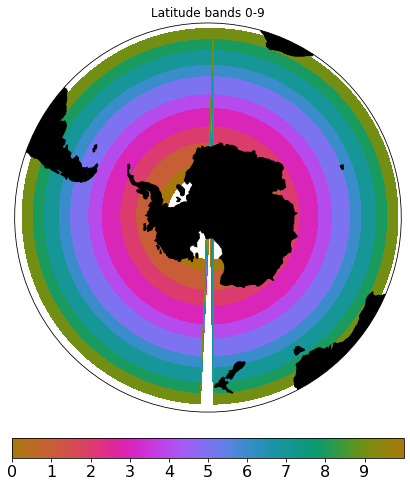

In [61]:
basin = nc.Dataset('/gpfs/data/greenocean/software/resources/ModelResources/BasinMasks/clq_basin_masks_ORCA.nc')
nav_lat = basin['Y'][:]
nav_lon = basin['X'][:]

lons = nav_lon[0:50,:]
lats = nav_lat[0:50,:]

tdat = np.zeros_like(lats)


for i in range(0,len(bounds)-1):
    tdat[bounds[i]:bounds[i+1],:] = i


tvmin = 0;tvmax = 10

fact = 0.4
ticks = np.arange(0,10,1); tfs = 12

tfig = plt.figure(figsize=[20*fact, 20*fact])
ax1 = tfig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(0, -90))

cb = plot_southern(tfig, ax1, lons, lats, tdat, tvmin, 
                  tvmax, ticks, northex = -35, fs = tfs,
                  tit = 'Latitude bands 0-9', cbarlab = '', tcmap = cm.phase, lm = True, cbr = True)


## extract mfdataset for the 6 runs

In [62]:
## extract timeseries 
exhorse = False

dsets  = ['TOM12_TJ_1ASA','TOM12_TJ_1BSA', 'TOM12_TJ_3ASA', 'TOM12_TJ_3BSA',\
          'TOM12_TJ_2ASA', 'TOM12_TJ_2BSA']
if exhorse:
    
    for d in dsets:
        print(d)
        ylist = ut.make_yearlist(1948,2100,'diad_T',d)
        with xr.set_options(enable_cftimeindex=True):
            TJ_1ASA = xr.open_mfdataset(ylist)
        TJ_1ASA['time_counter'] = TJ_1ASA.indexes['time_counter'].to_datetimeindex()
        #extract the relevant
        nav_lat = TJ_1ASA['nav_lat'][:,0].values
        nav_lon = TJ_1ASA['nav_lon'][0,:].values
        time_counter = TJ_1ASA['time_counter'].values
        Cflx = TJ_1ASA['Cflx'].values
        
        # define data with variable attributes
        data_vars = {'cflx':(['time_counter','nav_lat','nav_lon'], Cflx, 
                                 {'units': 'mol m-2 s-1', 
                                  'long_name':'free-fall velocity'})}

        # define coordinates
        coords = {'time_counter': (['time_counter'], time_counter),\
                 'nav_lat': (['nav_lat'], nav_lat),\
                 'nav_lon': (['nav_lon'], nav_lon)}

        # define global attributes
        attrs = {'author':'TJSJ', 
                 'email':'address@email.com'}

        # create dataset
        ds = xr.Dataset(data_vars=data_vars, 
                        coords=coords, 
                        attrs=attrs)
        
        tdir = '/gpfs/home/mep22dku/scratch/SOZONE/MO_RESULTS/EXTRACT/ncs/'
        fn = f'{tdir}/{d}_cflx_fullts.nc'
        ds.to_netcdf(fn)

In [63]:
tdir = '/gpfs/home/mep22dku/scratch/SOZONE/MO_RESULTS/EXTRACT/ncs/'
cflx_1ASA = xr.open_dataset(f'{tdir}TOM12_TJ_1ASA_cflx_fullts.nc')
cflx_1BSA = xr.open_dataset(f'{tdir}TOM12_TJ_1BSA_cflx_fullts.nc')
cflx_2ASA = xr.open_dataset(f'{tdir}TOM12_TJ_2ASA_cflx_fullts.nc')
cflx_2BSA = xr.open_dataset(f'{tdir}TOM12_TJ_2BSA_cflx_fullts.nc')
cflx_3ASA = xr.open_dataset(f'{tdir}TOM12_TJ_3ASA_cflx_fullts.nc')
cflx_3BSA = xr.open_dataset(f'{tdir}TOM12_TJ_3BSA_cflx_fullts.nc')




In [64]:
cflx_1ASA_blyat = np.zeros([1836,10])
for i in range(0,1836):
    tv = cflx_1ASA['cflx'].values
    for b in range(0,10):
        cflx_1ASA_blyat[i,b] = np.average(tv[i,bounds[b]:bounds[b+1],:], weights = csize[bounds[b]:bounds[b+1],:])
        
cflx_1BSA_blyat = np.zeros([1836,10])
for i in range(0,1836):
    tv = cflx_1BSA['cflx'].values
    for b in range(0,10):
        cflx_1BSA_blyat[i,b] = np.average(tv[i,bounds[b]:bounds[b+1],:], weights = csize[bounds[b]:bounds[b+1],:])
        
cflx_2ASA_blyat = np.zeros([1836,10])
for i in range(0,1836):
    tv = cflx_2ASA['cflx'].values
    for b in range(0,10):
        cflx_2ASA_blyat[i,b] = np.average(tv[i,bounds[b]:bounds[b+1],:], weights = csize[bounds[b]:bounds[b+1],:])
        
cflx_2BSA_blyat = np.zeros([1836,10])
for i in range(0,1836):
    tv = cflx_2BSA['cflx'].values
    for b in range(0,10):
        cflx_2BSA_blyat[i,b] = np.average(tv[i,bounds[b]:bounds[b+1],:], weights = csize[bounds[b]:bounds[b+1],:])
        
cflx_3ASA_blyat = np.zeros([1836,10])
for i in range(0,1836):
    tv = cflx_3ASA['cflx'].values
    for b in range(0,10):
        cflx_3ASA_blyat[i,b] = np.average(tv[i,bounds[b]:bounds[b+1],:], weights = csize[bounds[b]:bounds[b+1],:])
        
cflx_3BSA_blyat = np.zeros([1836,10])
for i in range(0,1836):
    tv = cflx_3BSA['cflx'].values
    for b in range(0,10):
        cflx_3BSA_blyat[i,b] = np.average(tv[i,bounds[b]:bounds[b+1],:], weights = csize[bounds[b]:bounds[b+1],:])
        


In [75]:
sc.scen[scens[s]]

{'hist_dir': 'hist/u-cj200_hist_1990start1990ozone/',
 'fut_dir': 'ssp370/u-cj504_ssp370_1990start1990ozone/',
 'name': '1990 OZONE \n HIGH TEMP.',
 'name2': '3B: Ozone1990-SSP370',
 'color': '#822722',
 'color2': 'mediumblue'}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


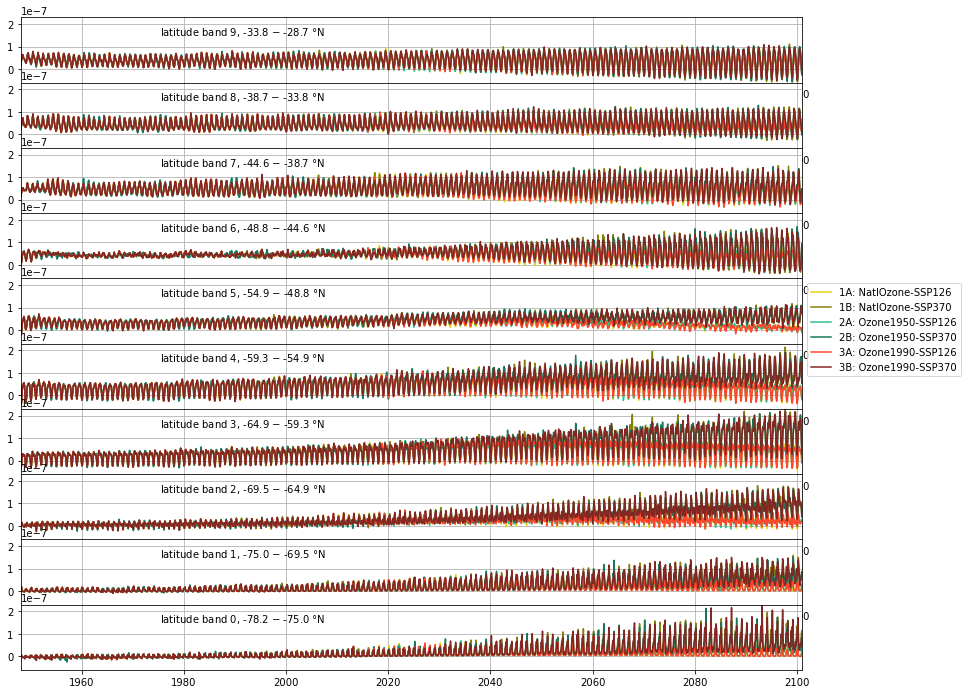

In [79]:
blyats = [cflx_1ASA_blyat, cflx_1BSA_blyat, cflx_2ASA_blyat, cflx_2BSA_blyat, cflx_3ASA_blyat, cflx_3BSA_blyat]
scens = ['1A', '1B', '2A', '2B', '3A', '3B']

fact = 0.45
fig, axs = plt.subplots(10,1, figsize=(14, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()
fig.subplots_adjust(wspace=0, hspace=0)
for i in range(0,10):
    pos = 9-i
    for s in range(0,6):
        tb = blyats[s]
        axs[i].plot(cflx_1ASA['time_counter'].values,tb[:,pos], alpha = 1, color = sc.scen[scens[s]]['color'], label = sc.scen[scens[s]]['name2'])
    
#     # axs[i].set_ylim([0,20])
#     # axs[i].set_xlim([0,19])
#     # axs[i].set_yticks([0,10,20])
#     # axs[i].set_xticks(np.arange(0,20,2))
#     # axs[i].grid()
#     # if i!= 9:
#     #     axs[i].set_xticks(np.arange(2,20,2))
#     #     axs[i].set_yticks([0,10,20], color = 'w')
#     #     axs[i].set_yticklabels([0,10,20], color = 'w')
    axs[4].legend(bbox_to_anchor = [1,1])
    axs[i].text(1930,1.5e-7,f'latitude band {pos}, {starts[pos]} $-$ {ends[pos]} $\degree$N')
    axs[i].set_ylim([-0.6e-7,2.3e-7])
    st = cflx_1ASA['time_counter'].values[0]
    en = cflx_1ASA['time_counter'].values[1835]
    axs[i].set_xlim([st,en])
    axs[i].grid()
#     # axs[9].set_ylabel('% of distribution')
#     # axs[9].set_xlabel('m s$^{-1}$')



look at:
- winds
- temp
- pco2
- TOM11_RW_t201
- amplitude
- seasonal cycle